In [1]:
include("standard_hopfield.jl")
using .SH, Statistics, LinearAlgebra, Plots

In [2]:
using DelimitedFiles

In [3]:
function reconstruction_prob(N::Int, pp::AbstractVector, α, nsweeps,
                             nsamples, β = 10, earlystop = 0)
    M = round(Int, N * α)
    
    len_pp = length(pp)
    probs = zeros(len_pp)
    error_bars = zeros(len_pp)
    magnetization = zeros(len_pp)
    
    for i in 1:len_pp
        probs_over_samples = zeros(nsamples)        
        #count = 0
        ms = zeros(nsamples)
        
        for sample in 1:nsamples
            ξ = generate_patterns(M, N)
            J = store(ξ)
            
            k = rand(1:M)
            σ = ξ[:, k]
            perturbed_σ = perturb(σ, pp[i])
                        
            perturbed_σ = monte_carlo(perturbed_σ, J, nsweeps, earlystop, β)
            
            m = overlap(perturbed_σ, σ)
            #print(m)
            if m >= N * 0.85
                probs_over_samples[sample] = 1
                #count += 1
            end
            ms[sample] = m
        end
        probs[i] = Statistics.mean(probs_over_samples)
        error_bars[i] = Statistics.std(probs_over_samples)/sqrt(nsamples)
        magnetization[i] = Statistics.mean(ms)
    end
    
    return probs, error_bars, magnetization
end
        

reconstruction_prob (generic function with 3 methods)

In [10]:
@time begin
    N = 1000
    pp = range( 0.05, 0.6, length = 25)
    α = 0.1
    nsweeps = 100
    β = 10^3
    nsamples = 3
    earlystop = 0

    a, b, c = reconstruction_prob(N, pp, α, nsweeps, nsamples, β, earlystop)
end

  6.927994 seconds (1.11 k allocations: 1.177 GiB, 1.60% gc time)


([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [994.6666666666666, 998.0, 997.3333333333334, 997.3333333333334, 992.6666666666666, 994.6666666666666, 999.3333333333334, 998.0, 998.0, 989.3333333333334  …  318.6666666666667, 158.66666666666666, 93.33333333333333, 97.33333333333333, -6.0, -17.333333333333332, -124.66666666666667, -60.0, -208.0, -137.33333333333334])

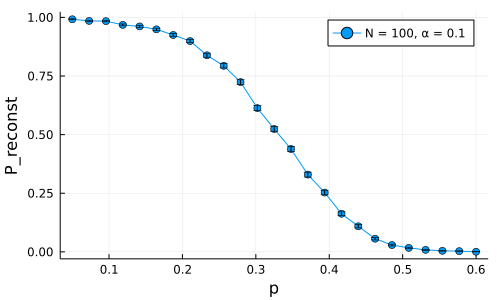

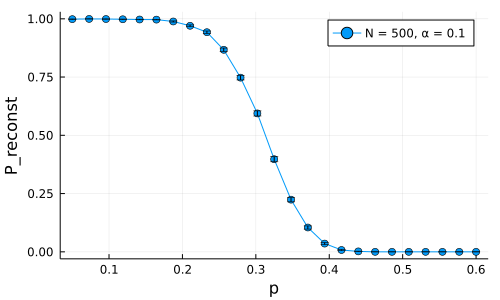

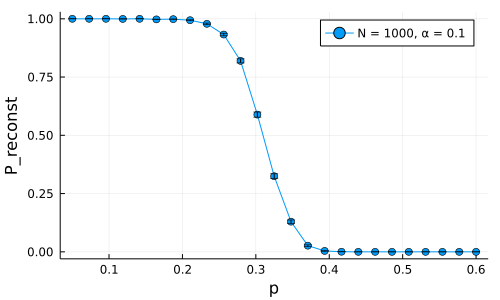

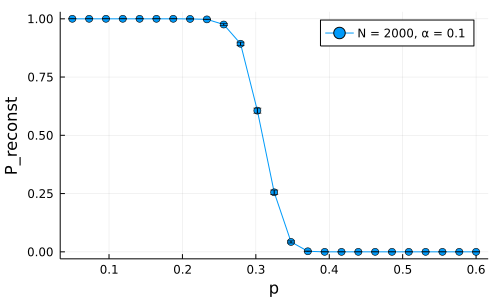

In [11]:
NN = [100, 500, 1000, 2000]
pp = range( 0.05, 0.6, length = 25 )
α = 0.1
nsweeps = 100
β = 10^3
nsamples = 2000
earlystop = 0

for i in 1:length(NN)
    N = NN[i]
    p, e, m = reconstruction_prob(N, pp, α, nsweeps, nsamples, β, earlystop)
    
    fig = plot(pp, p, size = (500,300), markershape =:circle, label = "N = $N, α = $α",
        yerrors = e, xlabel = "p", ylabel = "P_reconst") 
    display(fig)
    
    io = open("julia_data/alpha_01/probsN"*"$N"*".txt", "w") do io
          writedlm(io, [p e m])
    end
end

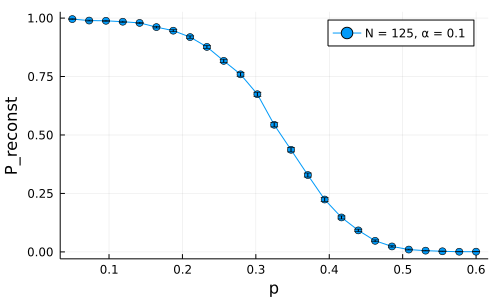

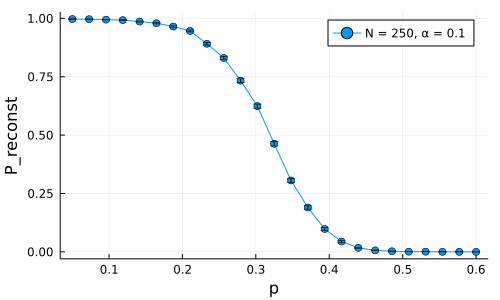

In [14]:
NN = [125, 250]
pp = range( 0.05, 0.6, length = 25 )
α = 0.1
nsweeps = 100
β = 10^3
nsamples = 3000
earlystop = 0

for i in 1:length(NN)
    N = NN[i]
    p, e, m = reconstruction_prob(N, pp, α, nsweeps, nsamples, β, earlystop)
    
    fig = plot(pp, p, size = (500,300), markershape =:circle, label = "N = $N, α = $α",
        yerrors = e, xlabel = "p", ylabel = "P_reconst") 
    display(fig)
    
    io = open("julia_data/alpha_01/probsN"*"$N"*".txt", "w") do io
          writedlm(io, [p e m])
    end
end

## try with different p range

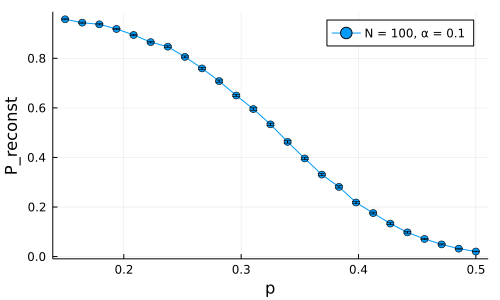

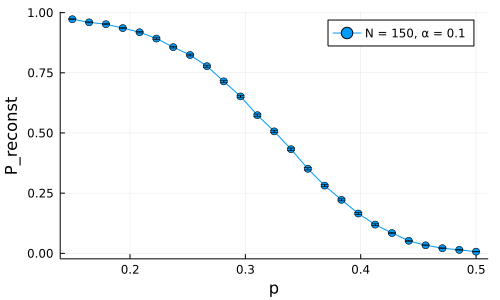

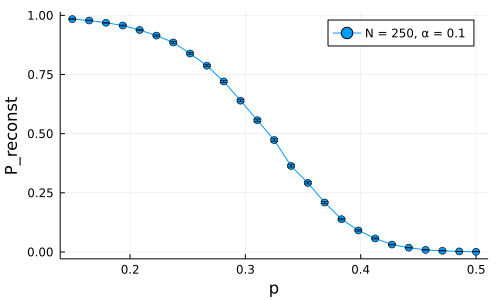

In [39]:
NN = [100, 150, 250]
pp = range( 0.15, 0.5, length = 25 )
α = 0.1
nsweeps = 100
β = 10^3
nsamples = 10000
earlystop = 0

for i in 1:length(NN)
    N = NN[i]
    p, e, m = reconstruction_prob(N, pp, α, nsweeps, nsamples, β, earlystop)
    
    fig = plot(pp, p, size = (500,300), markershape =:circle, label = "N = $N, α = $α",
        yerrors = e, xlabel = "p", ylabel = "P_reconst") 
    display(fig)
    
    io = open("julia_data/alpha_01/probsN"*"$N"*"pp.txt", "w") do io
          writedlm(io, [p e m])
    end
end

### Load the data

In [36]:
PN_100 = readdlm("julia_data/alpha_01/probsN100.txt", '\t', Float64, '\n')[:, 1]
PN_150 = readdlm("julia_data/alpha_01/probsN150.txt", '\t', Float64, '\n')[:, 1]

25-element Vector{Float64}:
 0.9952
 0.992
 0.9863
 0.982
 0.9728
 0.9655
 0.9416
 0.9133
 0.8702
 0.809
 0.7206
 0.6241
 0.4974
 0.3878
 0.2768
 0.1804
 0.102
 0.0593
 0.0275
 0.0141
 0.0046
 0.0017
 0.0007
 0.0002
 0.0002

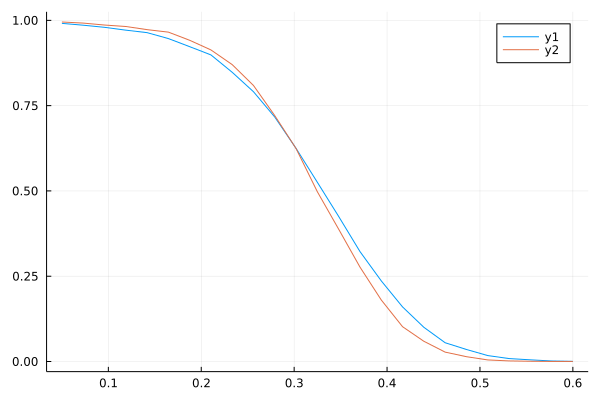

In [37]:
plot(pp, [PN_100 PN_150])
